In [1]:
import os
import json
import matplotlib.pyplot as plt
import re
import seaborn as sns
import itertools
import math
import numpy as np

In [2]:
def concat_metrics(folder_path: str):
    merged_data = {}

    for file in os.listdir(folder_path):
        if file.endswith('.json'):
            with open(os.path.join(folder_path, file), 'r') as f:
                data = json.load(f)
                merged_data.update(data)

    return merged_data

def plot_accuracy(folder_path, title):
    data = concat_metrics(folder_path)
    keys = sorted(data.keys(), key=lambda x: int(x))
    model_accuracies = [data[k].get('model_accuracy', 0) for k in keys]
    circuit_accuracies = [data[k].get('graph_accuracy', 0) for k in keys]

    plt.figure(figsize=(10, 6))
    plt.plot(keys, model_accuracies, marker='o', label='Model Accuracy')
    plt.plot(keys, circuit_accuracies, marker='s', label='Circuit (Graph) Accuracy', linestyle='--')

    plt.xlabel('Run ID')
    plt.ylabel('Accuracy')
    plt.title(f'Model vs Circuit Accuracy Across Runs:{title}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_faithfulness(folder_path, title):
    data = concat_metrics(folder_path)

    keys = sorted(data.keys(), key=lambda x: int(x))
    model_accuracies = [data[k].get('percentage_performance_kl', 0) for k in keys]
    plt.figure(figsize=(10, 6))
    plt.plot(keys, model_accuracies, marker='o', label='Model Accuracy')

    plt.xlabel('Run ID')
    plt.ylabel('Accuracy')
    plt.title(f'Model vs Circuit Accuracy Across Runs:{title}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import itertools

def plot_accuracy(folder_paths, titles=None):
    if isinstance(folder_paths, str):
        folder_paths = [folder_paths]

    if titles is None:
        titles = [f'Run {i}' for i in range(len(folder_paths))]

    plt.figure(figsize=(10, 6))
    
    # Color cycle
    colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for folder_path, title in zip(folder_paths, titles):
        data = concat_metrics(folder_path)
        keys = sorted(data.keys(), key=lambda x: int(x))

        model_accuracies = [data[k].get('model_accuracy', 0) for k in keys]
        circuit_accuracies = [data[k].get('graph_accuracy', 0) for k in keys]

        color = next(colors)

        plt.plot(keys, model_accuracies, marker='o', label=f'{title} - Model', color=color)
        plt.plot(keys, circuit_accuracies, marker='s', linestyle='--', label=f'{title} - Circuit', color=color)

    plt.xlabel('Run ID')
    plt.ylabel('Accuracy')
    plt.title('Model vs Circuit Accuracy Across Runs')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
def load_checkpoints_in_order(task_dir):
    checkpoints = []
    files = [f for f in os.listdir(task_dir) if f.endswith('.json')]

    checkpoint_files = []
    for filename in files:
        match = re.search(r'graph_(\d+)\.json', filename)
        if match:
            num = int(match.group(1))
            checkpoint_files.append((num, filename))

    checkpoint_files.sort(key=lambda x: x[0])

    for _, filename in checkpoint_files:
        checkpoint_path = os.path.join(task_dir, filename)
        with open(checkpoint_path, 'r') as f:
            data = json.load(f)
            checkpoints.append(data)

    return checkpoints

In [5]:
def count_nodes_per_checkpoint(checkpoints):
    node_counts = []
    for checkpoint in checkpoints:
        nodes = checkpoint['nodes']
        true_count = sum(1 for node, state in nodes.items() if state)
        node_counts.append(true_count)
    return node_counts

def calculate_node_changes(checkpoints):
    changes = []
    for i in range(1, len(checkpoints)):
        prev_nodes = checkpoints[i - 1]['nodes']
        curr_nodes = checkpoints[i]['nodes']
        added = sum(
            1 for node in curr_nodes
            if curr_nodes[node].get('in_graph', False) and not prev_nodes.get(node, {}).get('in_graph', False)
        )       

        removed = sum(
            1 for node in prev_nodes
            if prev_nodes[node].get('in_graph', False) and not curr_nodes.get(node, {}).get('in_graph', False)
        )
        changes.append(added + removed)

    return changes

def calculate_in_graph_changes_per_checkpoint(checkpoints):
    in_graph_changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']
        change_count = 0

        for edge in curr_edges.keys():
            prev_in_graph = prev_edges.get(edge, {}).get('in_graph', False)
            curr_in_graph = curr_edges[edge]['in_graph']
            if prev_in_graph != curr_in_graph: 
                change_count += 1

        in_graph_changes.append(change_count)

    return in_graph_changes

def calculate_edge_changes_top_95_percent(checkpoints):
    changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1].get('edges', {})
        curr_edges = checkpoints[i].get('edges', {})

        prev_scores = [abs(v['score']) for v in prev_edges.values() if v]
        curr_scores = [abs(v['score']) for v in curr_edges.values() if v]

        prev_threshold = np.percentile(prev_scores, 95) if prev_scores else 0
        curr_threshold = np.percentile(curr_scores, 95) if curr_scores else 0

        prev_high_edges = set(e for e, v in prev_edges.items() if v and abs(v['score']) >= prev_threshold)
        curr_high_edges = set(e for e, v in curr_edges.items() if v and abs(v['score']) >= curr_threshold)

        changed_edges = prev_high_edges.symmetric_difference(curr_high_edges)
        print(f"Step {i} -- Prev threshold: {prev_threshold}, Curr threshold: {curr_threshold}, Changes: {len(changed_edges)}")
        changes.append(len(changed_edges))

    return changes

def calculate_delta_S(total_dir):
    checkpoints = load_checkpoints_in_order(total_dir)
    changes = calculate_in_graph_changes_per_checkpoint(checkpoints)

    initial_edges = checkpoints[0].get('edges', {})
    S0 = len(initial_edges)
    if S0 == 0:
        return 0

    n = len(changes)
    sum_relative_changes = sum(change / S0 for change in changes)

    delta_S = (sum_relative_changes / n) * 100  # percentage
    return delta_S


def visualize_fine_tunings(total_dirs: list, type = 'edges'):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(10, 5))
    labels = []

    for total_dir in total_dirs:
        checkpoints = load_checkpoints_in_order(total_dir)
        if type == 'nodes': 
            changes = calculate_node_changes(checkpoints)
        else:
            changes = calculate_edge_changes_top_95_percent(checkpoints)

        transitions = range(1, len(changes) + 1)
        label = os.path.basename(os.path.dirname(total_dir.rstrip('/')))
        labels.append(label)

        plt.plot(transitions, changes, marker='o', linestyle='-', label=label)

    plt.xlabel('Checkpoint Transition', fontsize=14)
    plt.ylabel(f'Number of {type} Changes', fontsize=14)
    plt.title(f'{type} changes Between Checkpoints Across Runs', fontsize=16)
    plt.legend(title="Runs", fontsize=10)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return labels

### Add base

Step 1 -- Prev threshold: 3.7124983642833296e-10, Curr threshold: 3.333051656895232e-09, Changes: 12040
Step 2 -- Prev threshold: 3.333051656895232e-09, Curr threshold: 3.333979980979505e-09, Changes: 5452
Step 3 -- Prev threshold: 3.333979980979505e-09, Curr threshold: 3.2620764756075e-09, Changes: 4000
Step 4 -- Prev threshold: 3.2620764756075e-09, Curr threshold: 3.35146093100036e-09, Changes: 3362
Step 5 -- Prev threshold: 3.35146093100036e-09, Curr threshold: 3.3309254909852364e-09, Changes: 1890
Step 1 -- Prev threshold: 3.8893256948391265e-10, Curr threshold: 2.9556483038817296e-09, Changes: 12040
Step 2 -- Prev threshold: 2.9556483038817296e-09, Curr threshold: 2.93787678629087e-09, Changes: 7890
Step 3 -- Prev threshold: 2.93787678629087e-09, Curr threshold: 2.697521583883141e-09, Changes: 4852
Step 4 -- Prev threshold: 2.697521583883141e-09, Curr threshold: 2.7687005577092786e-09, Changes: 4034
Step 5 -- Prev threshold: 2.7687005577092786e-09, Curr threshold: 2.86202386234890

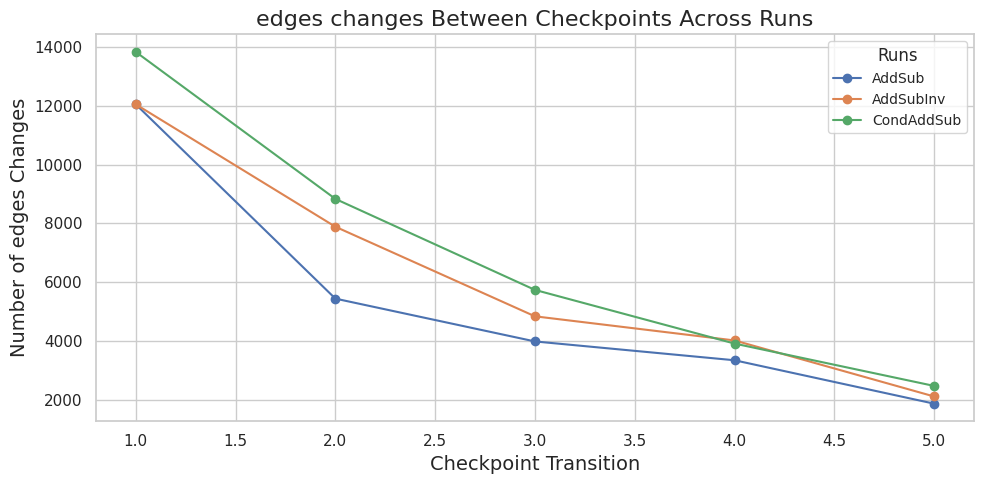

['AddSub', 'AddSubInv', 'CondAddSub']

In [11]:
paths = ['results_pythia_1.4B_05/AddSub/graphs','results_pythia_1.4B_05/AddSubInv/graphs','results_pythia_1.4B_05/CondAddSub/graphs' ]
visualize_fine_tunings(paths, type = 'edges')

### Addsub

Step 1 -- Prev threshold: 3.712602503203039e-10, Curr threshold: 2.897839435078707e-09, Changes: 11744
Step 2 -- Prev threshold: 2.897839435078707e-09, Curr threshold: 2.8509393512621274e-09, Changes: 5752
Step 3 -- Prev threshold: 2.8509393512621274e-09, Curr threshold: 2.8956375963673493e-09, Changes: 4888
Step 4 -- Prev threshold: 2.8956375963673493e-09, Curr threshold: 2.9855515837340317e-09, Changes: 2782
Step 5 -- Prev threshold: 2.9855515837340317e-09, Curr threshold: 3.001865600538166e-09, Changes: 1632
Step 1 -- Prev threshold: 3.889316702032626e-10, Curr threshold: 2.6350147397380398e-09, Changes: 12146
Step 2 -- Prev threshold: 2.6350147397380398e-09, Curr threshold: 2.324655401508835e-09, Changes: 6150
Step 3 -- Prev threshold: 2.324655401508835e-09, Curr threshold: 2.718881564334197e-09, Changes: 3962
Step 4 -- Prev threshold: 2.718881564334197e-09, Curr threshold: 2.7163515436967585e-09, Changes: 2938
Step 5 -- Prev threshold: 2.7163515436967585e-09, Curr threshold: 2.804

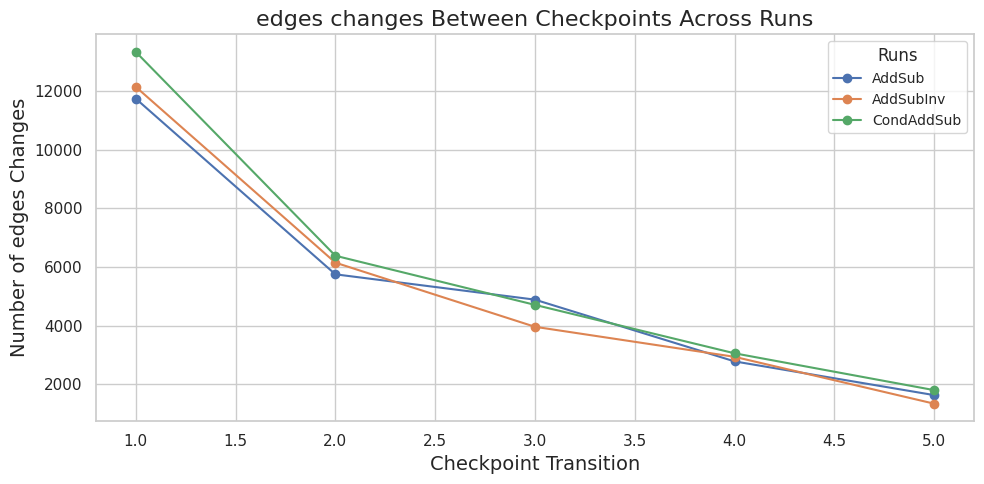

['AddSub', 'AddSubInv', 'CondAddSub']

In [32]:
paths = ['../results_pythia_1.4B/AddSub/graphs','../results_pythia_1.4B/AddSubInv/graphs', '../results_pythia_1.4B/CondAddSub/graphs']
visualize_fine_tunings(paths, type = 'edges')

In [26]:
for path in paths:
    print('delta_edge:',calculate_delta_S(path))

delta_edge: 2.3059876540543343
delta_edge: 2.2892268880700497
delta_edge: 2.527333439888031


In [ ]:
paths = ['../results_pythia_1.4B/AddSub/graphs','../results_pythia_1.4B/AddSubInv/graphs', '../results_pythia_1.4B/CondAddSub/graphs']
visualize_fine_tunings(paths, type = 'edges')